# Group project: YouTube Trending Videos Analysis

Authors: <br>
Rovan Elgendy <br>
Nikolaos Papanikolaou
<br>

Email: <br>
[rovan.elgendi@gmail.com](mailto:rovan.elgendi@gmail.com) <br>
[ns.papanikolaou1@gmail.com](mailto:ns.papanikolaou1@gmail.com)

### **Project Description:**  
The data chosen for our analysis project is the YouTube Trending Videos Dataset.
It is a collection of datasets for different regions. Each dataset contains one region with the videos that has been trending like DE for Germany, FR for France, GB for Great Britain etc.

The dataset contains columns of video_id, video_title, Channel_title, the number of views, likes, dislikes, comments enabled, number of ccomments, thumbnail link, description, and the date and time the video was trending.

##### In our analysis, we focused only on the region of Germany (DE), but we can easily extend the analysis to other regions by applying the functions we created to clean and transform the data.

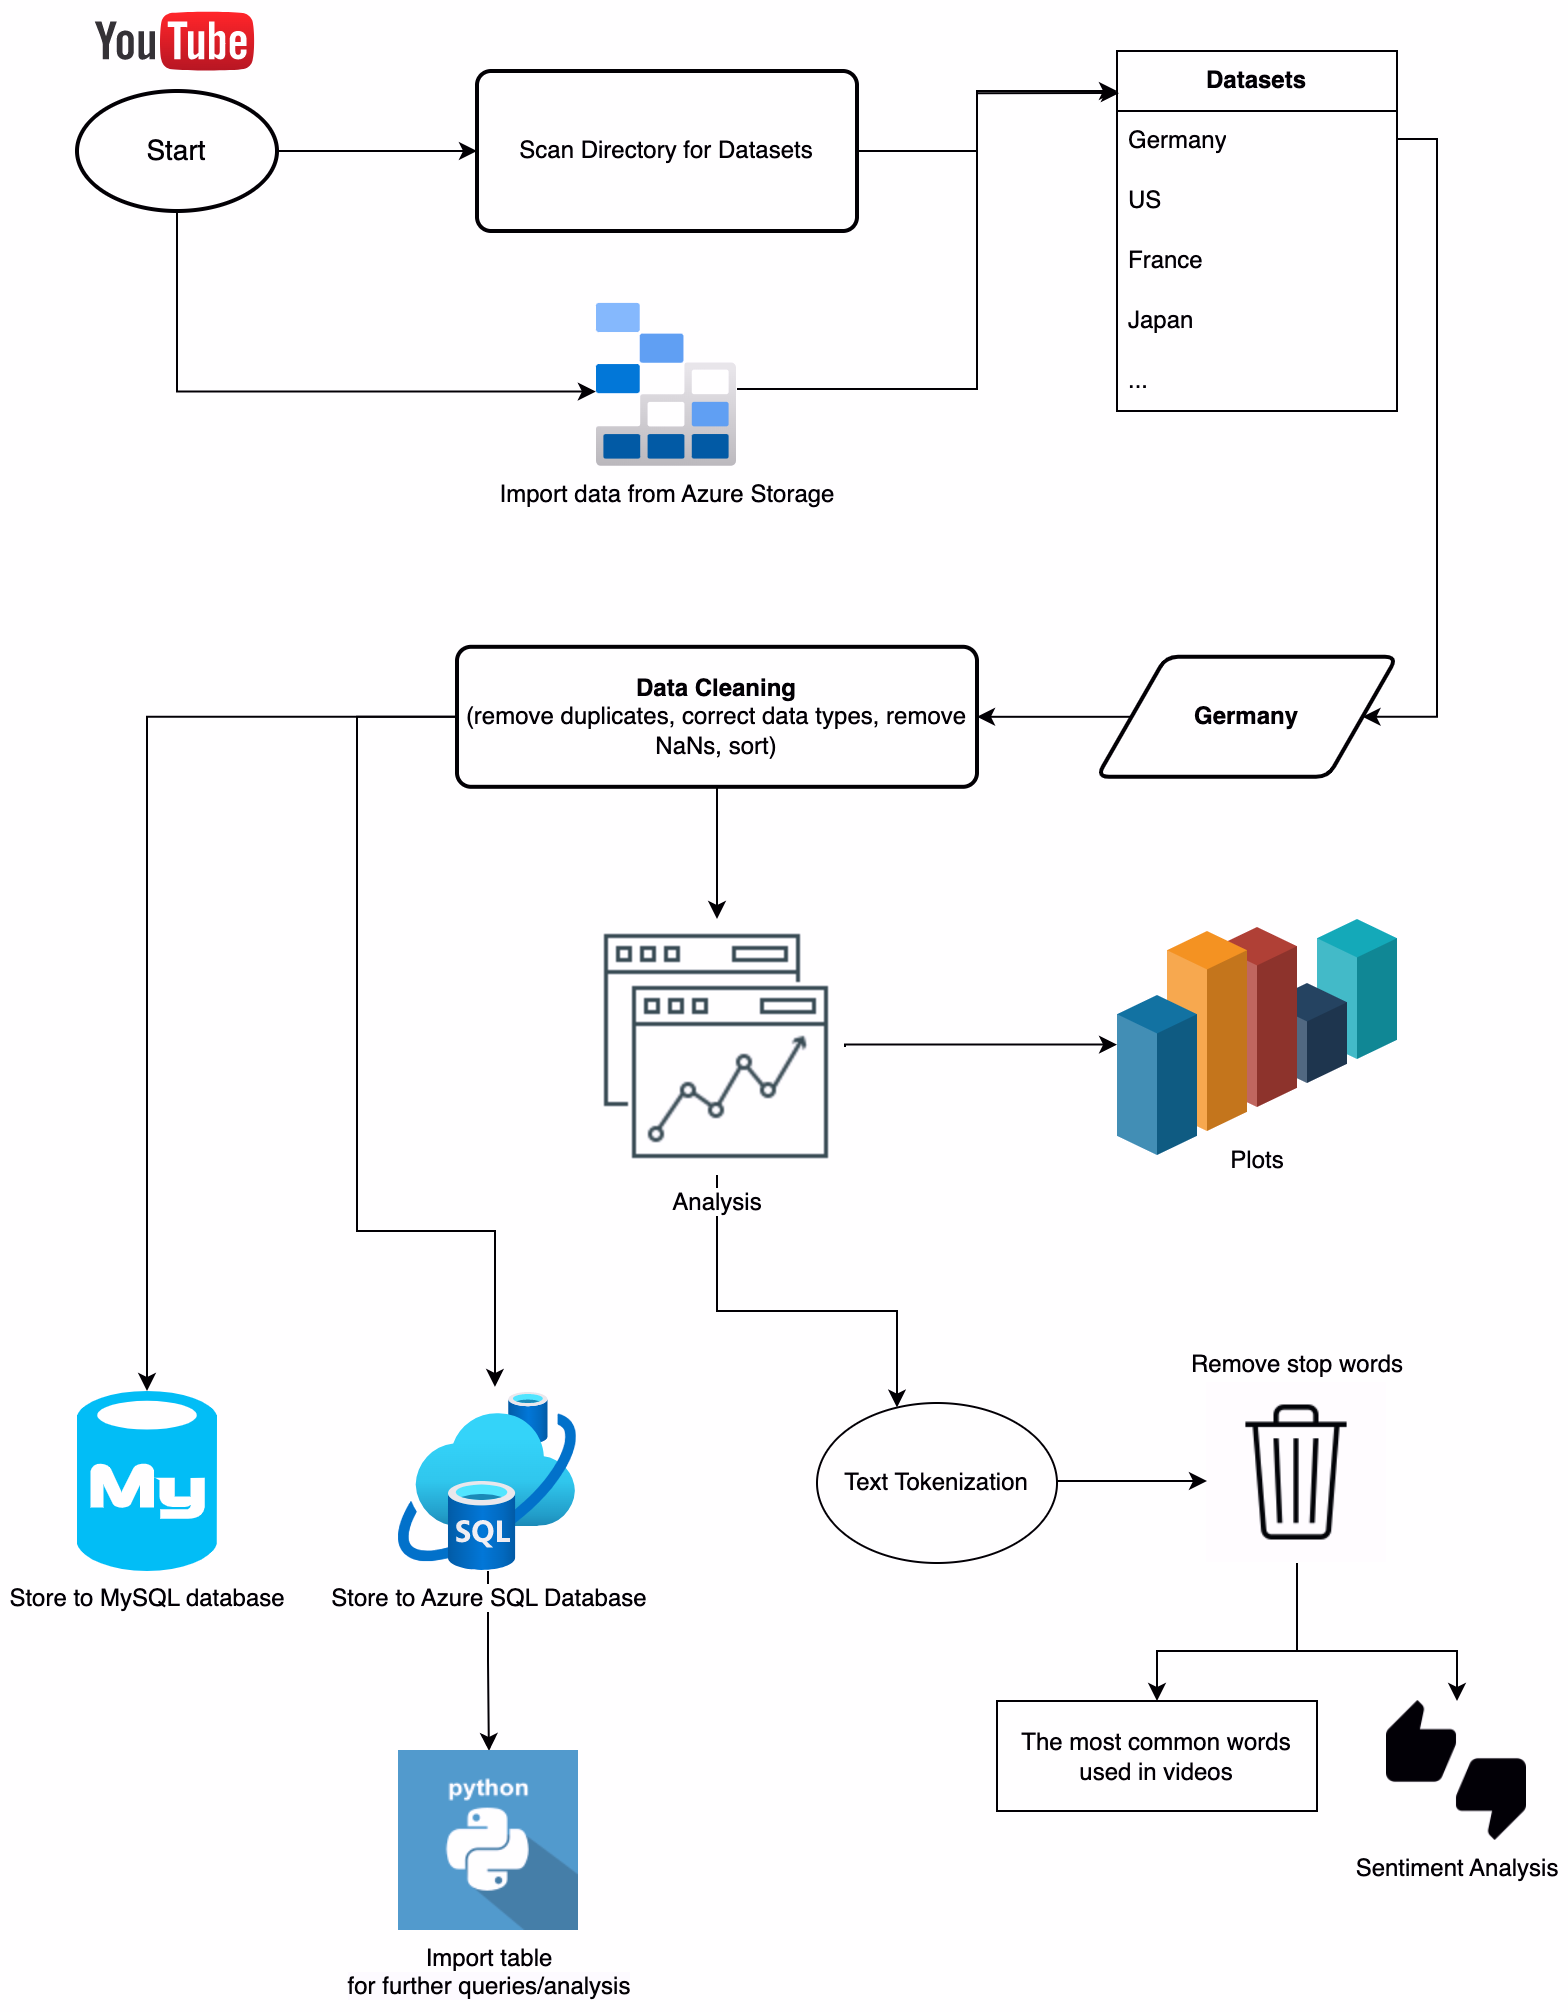

In [0]:
# Library imports
import pandas as pd
from datetime import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import json
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from stop_words import get_stop_words
from textblob import TextBlob
import os
from azure.storage.blob import BlobServiceClient
import io


# Step 1:  Import data

##### Approach 1:
We can simply download the data using the URL of the file from the azure storage.
The URL of the dataset used here is: https://relgendy.blob.core.windows.net/historicaldata/Project/data%20analysis%20project/DEvideos.csv

##### Approach 2:
We can  have successfully imported the dataset from an Azure container, however, to avoid unwanted charges on Azure we load the dataset from a local file. <br>
The code to load the dataset from Azure is commented out. <br>

From the connection between python and Azure storage by providing the connection string, the dataset code can be run smoothly without downloading the file.

In [0]:
connection_string = 'DefaultEndpointsProtocol=https;AccountName=relgendy;AccountKey=YTQ1cy1bOeU59C/5cp+Fjk+/DKHvr9LlimYMwuB+IU9yUtMzmvAISJy9SH4sRC9z87AyOM5ZTCyX+AStInnX4g==;EndpointSuffix=core.windows.net'
container_name = 'historicaldata'

blob_service_client = BlobServiceClient.from_connection_string(
    connection_string)
blob_client = blob_service_client.get_blob_client(
    container_name, 'Project/data analysis project/DEvideos.csv')


blob_data = blob_client.download_blob()
data = blob_data.content_as_text()
DE = pd.read_csv(io.StringIO(data))
DE.head()


##### Approach 3:
 We can also import all datasets automatically in a local directory and create a separate pandas dataframe for each dataset which is dynamically named. <br>

In [0]:
# List files in the input directory
%ls data/youtube_data


In [0]:
directory = 'data/youtube_data'
datasets = []  # List of dataset paths

for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        datasets.append(os.path.join(directory, filename))
        print(os.path.join(directory, filename))
    elif filename.endswith(".json"):
        continue


In [0]:
# We will create a dictionary to store the DataFrames. We can call each DataFrame by its country code.

# Function to read CSV files and return DataFrames
def read_csv_to_dataframe(file_path):
    return pd.read_csv(file_path, encoding='ISO-8859-1')


# Dictionary to store DataFrames with their respective names
dataframes = {}

# Loop through the dataset paths and read them into separate DataFrames
for dataset in datasets:
    country_code = os.path.basename(dataset).split("videos.csv")[0].upper()
    dataframes[country_code] = read_csv_to_dataframe(dataset)

# Dynamically create variables for each country code
for country_code, dataframe in dataframes.items():
    globals()[country_code] = dataframe


In [0]:
# For our analysis we will continue with the German dataset
# DE = dataframes['DE']

# For convenience we can also just read in a single CSV file
# the directory is 'data/youtube_data'
DE = pd.read_csv('data/youtube_data/DEvideos.csv')


### Profiling
We can take a quick look at a dataset using the profiling function. The profile will give us a quick overview of the dataset and the number of missing values in each column, the data type of each column and the number of unique values in each column etc. <br> 
We have commented it out since it needs a older version of python. <br>
The library needs python 3.10 or lower to run.
We ran in to create the profile report but we do not need to run it again since the output is already saved in the folder as profile.html. We can open it using any browser. <br>

In [0]:
# Needs python version <3.11
# df_raw = US
# !pip install ydata_profiling
# from ydata_profiling import ProfileReport
# profile = ProfileReport(df_raw, title='Pandas Profiling Report', explorative=True)
# profile.to_file(output_file="profile.html")
# profile.to_widgets()


# Step2: Function definitions for Data Cleaning

In [0]:
def remove_duplicates(df):
    '''Remove duplicate rows from the dataframe based on all columns'''
    df.drop_duplicates(keep='first', inplace=True)
    return df


def remove_nan_rows(dataframe, threshold=5):
    '''Remove rows with more than threshold number of NaN values'''
    num_nan_values = dataframe.isna().sum(axis=1)
    rows_to_remove = num_nan_values > threshold
    dataframe = dataframe.loc[~rows_to_remove, :]
    return dataframe


def adjust_datetime_format(dataframe):
    '''Adjust the format of the trending_date and publish_time columns'''
    dataframe['trending_date'] = pd.to_datetime(
        dataframe['trending_date'], format='%y.%d.%m')
    dataframe['publish_time'] = pd.to_datetime(dataframe['publish_time'])
    return dataframe


def set_index_and_sort(dataframe):
    '''Set the index of the dataframe to the publish_time column and sort the dataframe by the index'''
    dataframe.set_index('publish_time', inplace=True)
    dataframe.sort_index(ascending=True, inplace=True)
    return dataframe


The clean() function cleans the dataset once we import it successfully with pandas/Azure connection. <br>
The function takes the dataset as an input and returns the cleaned dataset. <br>
It performs the following steps
-  remove duplicated rows
- remove rows where there are NaN values in more than 5 columns
- set the datatype (dtype) of the dates to datetime format
- set the publish time as index and sort the dataset according to the index (ascending order of dates)

In [0]:
def clean(dataframe):
    print('The dataframe shape is: ', dataframe.shape)
    print('Starting data cleaning: detect duplicated rows, NaN values, adjust the dtype for dates,\n'
          'set an index and sort the dataframe based on the publish time in ascending order.')

    duplicate_rows = dataframe.duplicated()
    num_duplicate_rows = duplicate_rows.sum()
    print("Number of duplicate rows: ", num_duplicate_rows)

    if num_duplicate_rows > 0:
        dataframe = remove_duplicates(dataframe)
        print('Now the dataframe shape is: ', dataframe.shape)
    else:
        print('No duplicated rows to remove')

    print('Now to check the NaN values.')
    print(dataframe.isna().sum(axis=1))

    dataframe = remove_nan_rows(dataframe, threshold=5)
    print('After removing the NaN values from a row that has more than 5 columns with NaN values.', dataframe.shape)

    print('The publish time and trending date need to be adjusted to datetime format..\n',
          'Their dtypes before adjustment are:', dataframe['publish_time'].dtype, dataframe['trending_date'].dtype)

    dataframe = adjust_datetime_format(dataframe)
    print('After adjustment the publish time dtype is: ',
          dataframe['publish_time'].dtype, 'and trending_date dtype is:', dataframe['trending_date'].dtype)

    print('Setting the publish time as index and to be sorted in ascending order of dates.')
    set_index_and_sort(dataframe)

    return dataframe


In [0]:
DE = clean(DE)  # Clean the dataframe for Germany


In [0]:
DE.head()


In [0]:
DE.info()


In [0]:
DE.describe(include='all')


# Step 3: Data Visualization

Our analysis aims to explore various aspects of video popularity on a social media platform. Objectives include investigating the correlation between the number of views and likes by calculating r-value and p-value, as well as examining the same relationship using mean views and likes per video for comparison. The research will also determine the time it takes for a video to become trendy by calculating the number of days between the publishing time and the trendy dates. Additionally, the study will identify which category boasts the most popular views and likes, and rank the top 5 channels with the most views and the top 5 channels with the most likes.

In [0]:
# We plot a scatterplot to see if there is any correlation between the number of views and likes
sns.scatterplot(x='views', y='likes', data=DE)


In [0]:
# We calculate the Pearson correlation coefficient and p-value
pearson_corr, p_value = pearsonr(DE['views'], DE['likes'])
# 0.824 which gives positive correlation; means that when the number of views increase , the no. of likes increase
print("Pearson correlation coefficient:", pearson_corr)
# 0.0 means that the statistics here is significant and didn't occur by chance
print("p-value:", p_value)


In [0]:
# We show the mean number of views, likes, dislikes, comments per video id
mean_data = DE.groupby('video_id')[
    ['views', 'likes', 'dislikes', 'comment_count']].mean()
mean_data


In [0]:
# We plot a scatter plot of mean views vs. mean likes
sns.scatterplot(data=mean_data, x=mean_data['views'], y=mean_data['likes'])

# Set the tick label format to plain (no scientific notation)
plt.ticklabel_format(style='plain', axis='both')
plt.xticks(rotation=45)
plt.show()


In [0]:
# We check the r-value and p-value using the mean data to check if the statistics are to be trusted as well
# We calculate Pearson correlation coefficient and p-value
pearson_corr, p_value = pearsonr(mean_data['views'], mean_data['likes'])
# 0.787 which implies a positive correlation. This means that when the number of views increase, the number of likes increase also.
print("Pearson correlation coefficient:", pearson_corr)
# 0.0 means that the statistics here is significant and didn't occur by chance
print("p-value:", p_value)


We want to investigate how much time it takes for a video to become trending as soon as it gets published, by calculating the number of days between the publishing time and the trending dates.

In [0]:
# DE['days_to_trending'] = (DE['trending_date'] - DE.index).dt.days # We get an error as the trending date doesn't have time zone so we need to add it and make both with the same timezone
# localize the datetime objects to 'Europe/Berlin' timezone
DE['trending_date'] = DE['trending_date'].dt.tz_localize('UTC')
# For clarity we convert to the timezone we want in a septate line
DE['trending_date'] = DE['trending_date'].dt.tz_convert('Europe/Berlin')
DE.index = DE.index.tz_convert('Europe/Berlin')


In [0]:
# We calculate the number of days from the publish time to the trending date
DE['days_to_trending'] = (DE['trending_date'] - DE.index).dt.days
DE.head()


We show a scatter plot of the number of days between the publishing time and the trending dates for each video. We can see that most of the videos are trending within 10 days of publishing. However, there are some videos that are trending after 100 days of publishing. Before 2018 it took much more time for a video to become trending. After 2018, the number of days between the publishing time and the trending dates is much lower. This is probably due to the fact that YouTube is becoming more popular and more people are using it in Germany. Therefore, it is easier for a video to become trending.

In [0]:
plt.scatter(DE.index, DE['days_to_trending'])
plt.xlabel('Publish Time')
plt.ylabel('Days to Trending')
plt.show()


Next, we want to investigate the correlation between the number of views and days_to_trending by calculating r-value and p-value. We don't see a strong correlation between the number of views and days_to_trending. The r-value is 0.0065 and the p-value is 0.18. This means that there is a weak positive correlation between the number of views and days_to_trending, but the p-value is 0.18 which means that the correlation is not statistically significant.

In [0]:
# We check the r-value and p-value using the mean data to check if the statistics are to be trusted as well
# Calculate Pearson correlation coefficient and p-value
pearson_corr, p_value = pearsonr(DE['views'], DE['days_to_trending'])
print("Pearson correlation coefficient:", pearson_corr)
print("p-value:", p_value)


In [0]:
DE.head()


Now, we take a look at the monthly average number of days until a video becomes trending only for the year 2018 and after. We see that the average number of days is even less than a day.

In [0]:
DE_2018 = DE[DE.index.year >= 2018]
DE_monthly = DE_2018.resample('M').mean()
plt.plot(DE_monthly['days_to_trending'], '-')
# plt.scatter(DE_monthly.index, DE_monthly['days_to_trending']) # option 2
plt.xlabel('Publish Time')
plt.ylabel('Days to Trending')
plt.show()


We see that we have weak negative correlation but the p-value is 0.65 which means that the correlation is not statistically significant.

In [0]:
# We check the r-value and p-value using the mean data to check if the statistics are significant
# We calculate the Pearson correlation coefficient and p-value
pearson_corr, p_value = pearsonr(
    DE_monthly['views'], DE_monthly['days_to_trending'])
print("Pearson correlation coefficient:", pearson_corr)  # negative correlation
# 0.65 which implies that the correlation is not significant
print("p-value:", p_value)


### Category Analysis
Futhermore, we want to know which category has the most popular video by views and likes.
We will group our data by category_id and calculate sum of views and likes per category_id. <br>
We import the DE.JSON File which contains the category title with its id and merge it with the original dataset which contains only the category_id.

##### Approach 1:
We can use the azure storage connection to python, to download and read the JSON file.

In [0]:
from azure.storage.blob import BlobClient
import json
import io
connection_string = 'DefaultEndpointsProtocol=https;AccountName=relgendy;AccountKey=YTQ1cy1bOeU59C/5cp+Fjk+/DKHvr9LlimYMwuB+IU9yUtMzmvAISJy9SH4sRC9z87AyOM5ZTCyX+AStInnX4g==;EndpointSuffix=core.windows.net'
container_name = 'historicaldata'
blob_name = 'Project/data analysis project/DE_category_id.json'

blob_client = BlobClient.from_connection_string(
    connection_string, container_name, blob_name)

with blob_client:
    blob_data = blob_client.download_blob()
    data = blob_data.content_as_text()
    categories = json.loads(data)


##### Approach 2:
Download the JSON file using the URL from Azure storage

The JSON file containing the category titles for each category id is: <br>
https://relgendy.blob.core.windows.net/historicaldata/Project/data%20analysis%20project/DE_category_id.json

##### Approach 3 :

We can also simply import the JSON file from a local directory.

In [0]:
# Import the json file from the local directory
with open('data/youtube_data/DE_category_id.json', 'r') as f:
    categories = json.load(f)


In [0]:
# Create a DataFrame with category ID and category title
categories_df = pd.DataFrame([(c['id'], c['snippet']['title']) for c in categories['items']],
                             columns=['category_id', 'category_title'])

categories_df

In [0]:
categories_df.info()


In [0]:
DE.info()


In [0]:
# We change the data type of the category_id column to int
categories_df['category_id'] = categories_df['category_id'].astype('int')

In [0]:
# We cannot merge the two dataframes as the category_id column is of different data types
# merged_df = DE.merge(categories_df, left_on='category_id', right_index=True) # ERROR
# Again, we change the data type of the category_id column to int for the DE dataframe
DE['category_id'] = DE['category_id'].astype('int')

In [0]:
# Finally, we merge the two dataframes by on the category_id column
merged = DE.merge(categories_df, on='category_id')

In [0]:
# We take a look at the merged dataframe and see that the merge was successful and the category_title column was added
merged.head(3)

In [0]:
merged.describe(include='all', datetime_is_numeric=True)

In [0]:
# We calculate the total number of views and likes per category and sort them in descending order
views_by_category = merged.groupby('category_title')['views'].sum()
likes_by_category = merged.groupby('category_title')['likes'].sum()

# We sort the two series in descending order
views_by_category = views_by_category.sort_values(ascending=False)
likes_by_category = likes_by_category.sort_values(ascending=False)

In [0]:
views_by_category

In [0]:
likes_by_category

In [0]:
# Bar plot for total views by category
views_by_category.plot(kind='bar', title='Total Views by Category')
plt.show()


In [0]:
# Bar plot for likes by category
likes_by_category.plot(kind='bar', title='Total Likes by Category')
plt.show()

### Top 5 channels with the most views and likes

We want to know which channels have the most popular videos by views and likes. We will group our data by channel_title and calculate sum of views and likes per channel_title. We will then plot the top 5 channels with the most views and the top 5 channels with the most likes.

In [0]:
# We set the index to the channel_title column
data = DE.set_index(DE['channel_title'])
# We group by the channel_title and sum the views and likes
views_likes_by_channel = data.groupby(data.index)[['views', 'likes']].sum()
# We sort the values in descending order by views
views_sorted = views_likes_by_channel.sort_values(ascending=False, by='views')
# We sort the values in descending order by likes
likes_sorted = views_likes_by_channel.sort_values(ascending=False, by='likes')

display(views_sorted.head(5))  # We display the top 5 values sorted by views
display(likes_sorted.head(5))  # We display the top 5 values sorted by likes


In [0]:
# We subset the data to only include the top 5 channels by views
top_five_views = views_sorted.head(5)
top_five_views

In [0]:
# We subset the data to only include the top 5 channels by likes
top_five_likes = likes_sorted.head(5)
top_five_likes

In [0]:
# Another way to find the channel with the most views is to use the idxmax() method
# First we calculate the total views by channel
views_by_channel = DE.groupby('channel_title')['views'].sum()

# Then get the channel with the most views using the idxmax() method
channel_with_most_views = views_by_channel.idxmax()
channel_with_most_views


In [0]:
# We can do the same for the channel with the most likes
# Calculate the total likes by channel
likesby_channel = DE.groupby('channel_title')['likes'].sum()

# Then get the channel with the most views
channel_with_most_likes = likesby_channel.idxmax()
channel_with_most_likes


### Plotting the top 5 channels with the most views and the top 5 channels with the most likes

In [0]:
# We create bar plot for the channels with the most views
top_five_views.plot(kind='bar', title='Top 5 Channels by Views')
# Similarly, we create a bar plot for the channels with the most likes
top_five_likes.plot(kind='bar', title='Top 5 Channels by Likes')
plt.show()


# Step 4: Text Analysis
In Step 4, the focus shifts to text analysis, where the process begins with data cleaning by removing special characters and converting letters to lowercase. Subsequently, tokenization is performed, followed by the removal of stopwords. <br>
The primary objectives of this step are to identify the most common words used in video titles and to analyze their sentiment, determining whether the titles convey a positive, negative, or neutral tone. This analysis aims to shed light on potential trends or patterns in popular video titles.

In [0]:
# Text data analysis
# We extract all the columns with text data in a new dataframe
text_analysis = DE.loc[:, ['title', 'channel_title', 'tags']]
text_analysis
# text_analysis=text_analysis.apply(lambda x:x.astype('str').str.lower())

In [0]:
# We remove the unnecessary characters using lambda, str.replace()
text_analysis = text_analysis.apply(lambda x: x.str.replace('[^\w\s]', ' ', regex=True))


In [0]:
# Next, we tokenize the text using lower case text. We use the lambda function to apply the word_tokenize() function to each cell in the dataframe
token = text_analysis.applymap(lambda x: nltk.word_tokenize(str(x).lower()))
token


In [0]:
# Now we have the dataframe tokenized. We can get the frequency of the tokens using nltk.FreqDist() function
tokens = []
for row in token['title']:
    tokens += row

fdist = nltk.FreqDist(tokens)
display(fdist.most_common(20))


In [0]:
# The most common words used are meaningless words so we remove them using stopwords()
# We will combine stopwords from multiple sources, for the english and german language
# We also remove any numbers from the text

# list of stop words from one library
stop_words = list(get_stop_words('en'))
# list of stop words from another library
nltk_words = list(stopwords.words('english'))
# add german stopwords
nltk_words_de = list(stopwords.words('german'))
# we add some stopwords from another library
stop_words.extend(nltk_words)
# we add the german language as well
stop_words.extend(nltk_words_de)
# we add some words that we think are not relevant but are very common
added_words = ['and', 'video', 'vs']
# Add the extra words to the stop_words list
stop_words.extend(added_words)
# Convert each sublist to a tuple
token_tuples = [tuple(x) for x in token['title']]
# filtered_sentence = [w for w in token_tuples if w not in stop_words and not word.isnumeric()] # we can use this as well
filtered_sentence = []
for tup in token_tuples:
    for word in tup:
        if word not in stop_words and not word.isnumeric():
            filtered_sentence.append(word)


In [0]:
# We can see the first 10 stopwords
print(stop_words[0:10])
# We can see the first 10 tokens from which we will remove the stopwords
print(token_tuples[0:10])
# We can see the first 10 tokens after removing the stopwords
print(filtered_sentence[0:10])


In [0]:
# Calculate the total number of tokens in token_tuples before filtering stopwords
tokens_before_filtering = sum(len(tup) for tup in token_tuples)

# Calculate the total number of tokens in filtered_sentence after filtering stopwords
tokens_after_filtering = len(filtered_sentence)

print("Total tokens before filtering stopwords:", tokens_before_filtering)
print("Total tokens after filtering stopwords:", tokens_after_filtering)

### Calculate and plot the frequency distribution for the most common words used in the video titles

In [0]:
top = 10
word_dist = nltk.FreqDist(numeric)
result = pd.DataFrame(word_dist.most_common(top),
                      columns=['Word', 'Frequency'])

plt.figure(figsize=(10, 10))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word", y="Frequency", data=result.head(10))


### Sentiment Analysis

In [0]:
# We can use the TextBlob library to calculate the sentiment of the text in the titles
listing = []
token1 = token['title']
for word in token_tuples[0:100]:
    for word1 in word:
        blob = TextBlob(word1)
        listing.append((row, blob.sentiment.polarity,
                       blob.sentiment.subjectivity))
        exp = pd.DataFrame(listing, columns=[
                           'word', 'sentiment', 'positivity'])


In [0]:
# We classify the sentiment of the words into positive, negative and neutral
def f(exp):
    if exp['sentiment'] > 0:
        val = "Positive"
    elif exp['sentiment'] == 0:
        val = "Neutral"
    else:
        val = "Negative"
    return val


In [0]:
# We apply the function to the dataframe and plot the results
exp['Sentiment_Type'] = exp.apply(f, axis=1)

plt.figure(figsize=(10, 10))
sns.set_style("whitegrid")
ax = sns.countplot(x="Sentiment_Type", data=exp)


# Analysis Summary:

The data analysis of the project reveals that the most popular videos are predominantly TV show episodes, particularly from "The Late Show with Stephen Colbert," available in various languages. The top five categories overall, based on likes, include Entertainment, Music, People & Blogs, Film & Animation, and Comedy, while Sports is a major category in terms of views. A positive correlation is observed between the number of views and likes for a video. Moreover, post-2018, the gap between a video's trending date and its publishing date has significantly decreased, suggesting that YouTube has gained popularity among people in Germany since 2018.

# Import the dataset to a table in Azure sql and then connect to the azure sql by pyodbc library 
[Not yet working, had some issues with drivers]

In [0]:
from queue import Queue
from threading import Lock
import pyodbc
from getpass import getpass
import pandas as pd

server = 'trainingtestc339.database.windows.net'
database = 'trainingtest'
username = 'c339'
# password = getpass('Rovy0191654747.')
password = 'Rovy0191654747.'
# here make sure that you have the driver version, otherwise install it from microsoft
driver = '{ODBC Driver 17 for SQL Server}'
# https://learn.microsoft.com/en-us/sql/connect/odbc/download-odbc-driver-for-sql-server?view=sql-server-ver16
connection_string = f"DRIVER={driver};SERVER={server};DATABASE={database};UID={username};PWD={password}"
max_con = 50
connection_pool = Queue(max_con)
lock = Lock()


# create connections and add them to the queue
for i in range(max_con):
    connection_pool.put(pyodbc.connect(connection_string))


# define a function to get connection from queue
def get_Connection():
    with lock:
        if not connection_pool.empty():
            return connection_pool.get()
    # if queue is empty, raise an exception
    raise Exception("Maximum number of connections reached")


def release_connection(connection):
    with lock:
        connection_pool.put(connection)


DE = pd.read_csv(
    'data sets\\data analysis project\\data\\youtube_data\\DEvideos.csv', error_bad_lines=False)
DE = pd.DataFrame(DE)
# Replace missing values with NULL
DE = DE.where(pd.notnull(DE), None)
# connection=get_Connection()
# cursor=connection.cursor()

# cursor.execute('select * from DE')  # query to call the database
for i, row in DE.iterrows():

    connection = get_Connection()
    cursor = connection.cursor()
    sql = "INSERT INTO DE (video_id,trending_date ,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description1) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)"
    val = tuple(row.values)

    cursor.execute(sql, val)
    connection.commit()
    cursor.close()

    release_connection(connection)


# Write the data to a SQLite database
Finally, we write the data to a SQLite database and run some queries on it.

In [0]:
import sqlite3
from sqlite3 import Error
import pandas as pd

# Function to create a SQLite connection
def create_connection(db_file):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        print(f"SQLite connection created: {db_file}")
    except Error as e:
        print(e)
    return conn


# Define the SQLite database file
sqlite_file = "data/DE_videos.db"

# Create the SQLite connection
conn = create_connection(sqlite_file)

# Upload the 'DE' DataFrame to the SQLite database
DE.to_sql("DE_videos", conn, if_exists="replace", index=False)

# Close the connection
conn.close()

### Execute some queries on the SQLite database
#### 1. Select the first 10 rows from the DE_videos table

In [0]:
conn = create_connection(sqlite_file)

query1 = "SELECT * FROM DE_videos LIMIT 10;"
result1 = pd.read_sql_query(query1, conn)

conn.close()

display(result1)

#### 2. Select the top 5 channels with the most views:

In [0]:
conn = create_connection(sqlite_file)

query2 = """
SELECT channel_title, SUM(views) as total_views
FROM DE_videos
GROUP BY channel_title
ORDER BY total_views DESC
LIMIT 5;
"""
result2 = pd.read_sql_query(query2, conn)

conn.close()

print(result2)

#### 3. Select the 10 most liked videos

In [0]:
conn = create_connection(sqlite_file)

query4 = """
SELECT title, channel_title, likes
FROM DE_videos
ORDER BY likes DESC
LIMIT 10;
"""
result4 = pd.read_sql_query(query4, conn)

conn.close()

display(result4)

#### 4. Find the average number of views, likes, and dislikes per video for each channel:

In [0]:
conn = create_connection(sqlite_file)

query5 = """
SELECT channel_title, AVG(views) as avg_views, AVG(likes) as avg_likes, AVG(dislikes) as avg_dislikes
FROM DE_videos
GROUP BY channel_title;
"""
result5 = pd.read_sql_query(query5, conn)

conn.close()

display(result5)

#### 5. Select the top 10 videos with the highest like to dislike ratio (ignoring videos with less than 1000 views to avoid outliers)

In [0]:
conn = create_connection(sqlite_file)

query6 = """
SELECT title, channel_title, likes, dislikes, (1.0 * likes / dislikes) as like_dislike_ratio
FROM DE_videos
WHERE views > 1000
ORDER BY like_dislike_ratio DESC
LIMIT 10;
"""
result6 = pd.read_sql_query(query6, conn)

conn.close()

display(result6)